In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf


In [3]:
seed = 42

os.listdir('/kaggle/input/')

['cassava-leaf-disease-models', 'cassava-leaf-disease-classification']

In [4]:
images_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')#, dtype = str)
images_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
images_df = images_df.sample(frac = 1, random_state = seed)
images_df.head()

,image_id,label
9134,2615227158.jpg,4
1580,1277648239.jpg,3
7304,2305895487.jpg,3
13196,336299725.jpg,2
5333,1951270318.jpg,2


In [6]:
train_folder = '/kaggle/input/cassava-leaf-disease-classification/train_images/'
images_df['image path'] = train_folder + images_df['image_id']
images_df.head()

,image_id,label,image path
9134,2615227158.jpg,4,/kaggle/input/cassava-leaf-disease-classificat...
1580,1277648239.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
7304,2305895487.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
13196,336299725.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...
5333,1951270318.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...


In [7]:
print(len(images_df))

21397


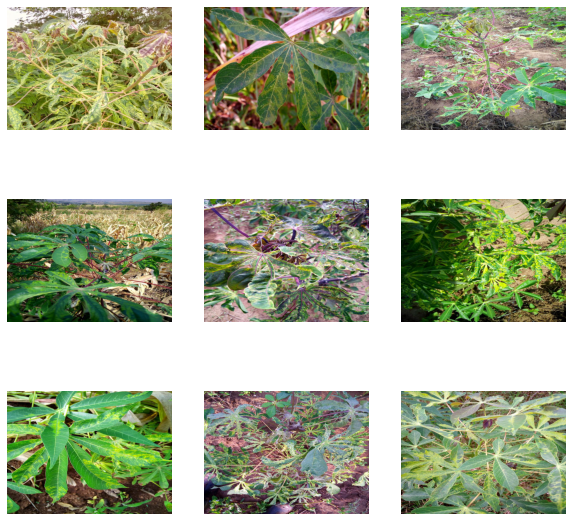

In [8]:
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(images_df.sample(9)['image path']):
    ax = plt.subplot(3, 3, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    #plt.title(int(label))
    plt.axis("off")


In [9]:
train_val_split = 0.9
train_count = int(len(images_df) * train_val_split)
val_count = int(len(images_df) * (1 - train_val_split))
print(f'Number of training samples {train_count}')
print(f'Number of validation samples {val_count}')

Number of training samples 19257
Number of validation samples 2139


In [10]:
train_images_df = images_df[:train_count]
val_images_df = images_df[train_count:]

In [11]:
batch_size = 8
image_size = 600
input_shape = (image_size, image_size, 3)
dropout_rate = 0.4
classes_to_predict = np.sort(train_images_df['label'].unique())
print(classes_to_predict)

[0 1 2 3 4]


In [12]:
#train_images_df.label.astype(int)
print(train_images_df.dtypes)

image_id      object
label          int64
image path    object
dtype: object


#Data augmentation with ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                              rotation_range = 40,
                                                              width_shift_range = 0.2,
                                                              height_shift_range = 0.2,
                                                              brightness_range = (0.6, 1.2),  
                                                              shear_range = 0.2,
                                                              zoom_range = 0.2,
                                                              horizontal_flip = True,
                                                              fill_mode = 'nearest')
train_generator = train_datagen.flow_from_dataframe(train_images_df,
                                                   directory = train_folder,
                                                   x_col = 'image_id',
                                                   y_col = 'label',
                                                   target_size = (image_size, image_size),
                                                   color_mode = 'rgb',
                                                   class_mode = 'sparse',
                                                   batch_size = batch_size)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_dataframe(val_images_df,
                                               directory = train_folder,
                                               x_col = 'image_id',
                                               y_col = 'label',
                                               target_size = (image_size, image_size),
                                               color_mode = 'rgb',
                                               class_mode = 'sparse',
                                               batch_size = batch_size)

In [13]:
train_data = tf.data.Dataset.from_tensor_slices((train_images_df['image path'].values, train_images_df['label'].values))
val_data = tf.data.Dataset.from_tensor_slices((val_images_df['image path'].values, val_images_df['label'].values))

In [14]:
autotune = tf.data.AUTOTUNE
print(autotune)

-1


In [15]:
def load_image_and_label_from_path(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    return image, label

train_data = train_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)
val_data = val_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)

In [16]:
train_data_batches = train_data.shuffle(buffer_size = 1000).batch(batch_size = batch_size).prefetch(buffer_size = autotune)
val_data_batches = val_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

In [19]:
print(train_data_batches)

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.uint8, tf.int64)>


In [22]:
def load_image_and_label_from_path_for_adapt(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
    return image, label

adapt_data = tf.data.Dataset.from_tensor_slices((train_images_df['image path'].values, train_images_df['label'].values))
adapt_data = adapt_data.map(load_image_and_label_from_path_for_adapt, num_parallel_calls = autotune)
adapt_data = adapt_data.prefetch(buffer_size = autotune)

In [24]:
augment_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.2)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

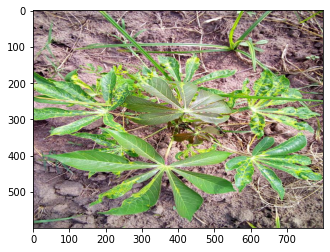

(800, 600)

In [25]:
preview = Image.open(images_df.iloc[1]['image path'])
plt.imshow(preview)
plt.show()
preview.size

(1, 600, 800, 3)
(1, 600, 600, 3)


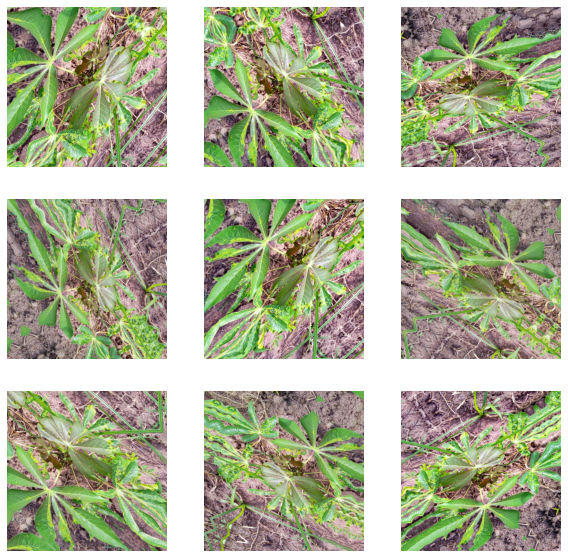

In [26]:
plt.figure(figsize=(10, 10))
image = tf.expand_dims(np.array(preview), 0)
print(image.shape)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_layers(image)
    plt.imshow(augmented_image[0])
    #plt.title(int(label))
    plt.axis("off")
print(augmented_image.shape)    

In [27]:
from tensorflow.keras.applications import EfficientNetB3
model = EfficientNetB3(weights = 'imagenet',
                       include_top = False,
                       drop_connect_rate = 0.4)
                       #input_shape = input_shape)

43941888/43941136 [==============================] - 0s 0us/step


In [20]:
model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [28]:
model.trainable = False

In [29]:
def build_model(base_model):
    inputs = tf.keras.layers.Input(shape = input_shape)
    x = augment_layers(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(len(classes_to_predict), activation = 'softmax')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    return model

In [30]:
final_model = build_model(model)

final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 600, 600, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 7,685
Non-trainable params: 10,783,535
_____________________________________________

In [34]:
epochs = 10
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                             patience = 3),
             tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model',
                                                monitor='val_loss', 
                                                save_best_only=True)]
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

final_model.compile(loss = loss_function,
                   optimizer = optimizer,
                   metrics = ['acc'])

In [25]:
hist = final_model.fit(train_data_batches,
                      epochs = epochs,
                      validation_data = val_data_batches,
                      callbacks = callbacks)

Epoch 1/10
2408/2408 [==============================] - 429s 168ms/step - loss: 1.4612 - acc: 0.6451 - val_loss: 1.6521 - val_acc: 0.6995
Epoch 2/10
2408/2408 [==============================] - 373s 154ms/step - loss: 1.7715 - acc: 0.6730 - val_loss: 1.1338 - val_acc: 0.7458
Epoch 3/10
2408/2408 [==============================] - 371s 153ms/step - loss: 1.7669 - acc: 0.6774 - val_loss: 1.0841 - val_acc: 0.7346
Epoch 4/10
2408/2408 [==============================] - 371s 153ms/step - loss: 1.7649 - acc: 0.6789 - val_loss: 1.1308 - val_acc: 0.7463
Epoch 5/10
2408/2408 [==============================] - 369s 152ms/step - loss: 1.8464 - acc: 0.6797 - val_loss: 1.0210 - val_acc: 0.7593
Epoch 6/10
2408/2408 [==============================] - 371s 153ms/step - loss: 1.8180 - acc: 0.6868 - val_loss: 1.0086 - val_acc: 0.7621
Epoch 7/10
2408/2408 [==============================] - 368s 152ms/step - loss: 1.8411 - acc: 0.6826 - val_loss: 1.0567 - val_acc: 0.7640
Epoch 8/10
2408/2408 [============

In [28]:
final_model.save_weights('Checkpoint_val_loss_1p08') 

In [32]:
final_model.load_weights("../input/model-weights/Checkpoint_val_loss_1p08.h5")

In [36]:
pred = final_model.evaluate(val_data_batches)

  7/268 [..............................] - ETA: 20:47 - loss: 1.2941 - acc: 0.7063

KeyboardInterrupt: 

In [29]:
! ls

Checkpoint_val_loss_1p08.data-00000-of-00001  __notebook_source__.ipynb
Checkpoint_val_loss_1p08.h5		      checkpoint
Checkpoint_val_loss_1p08.index


In [31]:
! pwd

/kaggle/working


In [32]:
from IPython.display import FileLink
FileLink('Checkpoint_val_loss_1p08.h5')

/kaggle/working/Checkpoint_val_loss_1p08.h5